In [ ]:
import numpy as np
from scipy.optimize import minimize
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [ ]:
def get_stock_data(symbol, start_dt, end_dt):
    stock_data = yf.download(symbol, start=start_dt, end=end_dt)
    return stock_data

In [ ]:
def ema(data, duration):
    return data['Close'].ewm(span=duration, adjust=False).mean()

In [ ]:
def objective_function(weights, cov_matrix, expected_returns, risk_aversion):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_return = np.dot(expected_returns, weights)
    return -1 * (portfolio_return - risk_aversion * portfolio_variance)

In [ ]:
def constraint(weights):
    return np.sum(weights) - 1.0

In [ ]:
def maximize_objective(expected_returns, covariance_matrix, risk_aversion):
    num_assets = len(expected_returns)
    initial_weights = np.ones((num_assets,)) / num_assets
    bounds = tuple((0, 1) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': constraint})
    result = minimize(objective_function, initial_weights, args=(covariance_matrix, expected_returns.flatten(), risk_aversion), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [ ]:
def select_portfolio(symbols, start_dt, end_dt):
    portfolios = []

    current_date = datetime.strptime(start_dt, '%Y-%m-%d')
    end_date = datetime.strptime(end_dt, '%Y-%m-%d')

    while current_date <= end_date:
        current_month_start = current_date.replace(day=1)
        next_month_start = (current_date + timedelta(days=32)).replace(day=1)  # Move to the next month

        # Fetch stock data for the current month
        stock_data_dict = {}
        for symbol in symbols:
            stock_data = get_stock_data(symbol, current_month_start, next_month_start)
            if stock_data is not None and not stock_data.empty:
                stock_data_dict[symbol] = stock_data

        # Calculate EMAs and select stocks for the portfolio
        portfolio = []
        for symbol, stock_data in stock_data_dict.items():
            monthly_data = stock_data.resample('D').first()

            ema_9 = ema(monthly_data, 9).iloc[-1]
            ema_21 = ema(monthly_data, 21).iloc[-1]

            if ema_9 > ema_21:
              portfolio.append(symbol)

        # Append the portfolio to the list
        portfolios.append((current_month_start, portfolio))

        # Move to the next month
        current_date = next_month_start

    return portfolios

In [ ]:
def get_optimal_weights(selected_portfolio, start_dt, end_dt, risk_aversion):
    optimal_weights_list = []

    for date, portfolio in selected_portfolio:
        stock_data_dict = {}
        for symbol in portfolio:
            stock_data = get_stock_data(symbol, start_dt, end_dt)
            if stock_data is not None and not stock_data.empty:
                stock_data_dict[symbol] = stock_data

        if not stock_data_dict:
            continue  # Skip if no valid stock data

        returns_matrix = np.vstack([np.log(stock_data_dict[symbol]['Close'] / stock_data_dict[symbol]['Close'].shift(1)).dropna().values for symbol in portfolio])

        if returns_matrix.size == 0:
            continue  # Skip if returns_matrix is empty

        expected_returns = np.mean(returns_matrix, axis=1)
        covariance_matrix = np.cov(returns_matrix)
        expected_returns = expected_returns.reshape(-1, 1)
        covariance_matrix = covariance_matrix + np.eye(len(expected_returns)) * 1e-6

        optimal_weights = maximize_objective(expected_returns, covariance_matrix, risk_aversion)
        optimal_weights_list.append((date, portfolio, optimal_weights))

    return optimal_weights_list

In [ ]:
def plot_pie_chart(date, portfolio, weights):
    plt.figure(figsize=(8, 8))
    plt.pie(weights, labels=portfolio, autopct='%1.1f%%', startangle=140)
    plt.title(f'Portfolio Weightage for {date.strftime("%Y-%m-%d")}')
    plt.show()

In [ ]:
def calculate_cagr(optimal_weights_list):  # Removed the portfolio_periods argument
    cumulative_returns = []

    for date, portfolio, weights in optimal_weights_list:
        # Access start_dt and end_dt directly from the tuple
        start_dt, end_dt = date, date + timedelta(days=32)

        # Fetch stock data for the current portfolio period
        stock_data_dict = {}
        for symbol in portfolio:
            if symbol not in stock_data_dict:
                stock_data_dict[symbol] = get_stock_data(symbol, start_dt, end_dt)

        if not stock_data_dict:
            continue  # Skip if no valid stock data

        daily_returns = np.vstack([np.log(stock_data_dict[symbol]['Close'] / stock_data_dict[symbol]['Close'].shift(1)).dropna().values for symbol in portfolio])

        if daily_returns.size == 0:
            continue  # Skip if returns_matrix is empty

        # Calculate time-weighted returns for each portfolio
        weighted_returns = np.average(daily_returns, axis=0, weights=weights)  # Use weighted average
        cumulative_return = np.cumprod(1 + weighted_returns)[-1] - 1
        cumulative_returns.append(cumulative_return)

    # Compute the overall CAGR using the geometric mean of cumulative returns
    net_cagr = (np.prod(1 + np.array(cumulative_returns)) ** (1 / len(cumulative_returns))) - 1

    return net_cagr

In [ ]:
def plot_pie_chart(date, portfolio, weights):
    plt.figure(figsize=(8, 8))
    plt.pie(weights, labels=portfolio, autopct='%1.1f%%', startangle=140)
    plt.title(f'Portfolio Weightage for {date.strftime("%Y-%m-%d")}')
    plt.show()

ecommerce_symbols = ['AMZN', 'BABA', 'EBAY', 'MELI', 'PDD', 'RKUNF', 'SHOP']
banks_symbols = ['SBIN.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'AXISBANK.NS', 'KOTAKBANK.NS', 'PNB.NS', 'BANKBARODA.NS']
automobiles_symbols = ['TSLA', 'TM', 'GM', 'F', 'STLA', 'HMC', 'RACE']
aviation_symbols = ['BA', 'LMT', 'HON', 'ESLT', 'RTX', 'NOC', 'TDG']
oil_symbols = ['SLB', 'CVX', 'EQNR', 'XOM', 'COP', 'TTE', 'BP']
start_dt = '2019-05-01'
end_dt = '2022-05-01'

i = int(input(" E-Commerce: 1 \n Banks: 2 \n Automobiles: 3 \n Aviation: 4 \n Oil: 5 \n Enter the sector you wish to use: "))
if i == 1:
    symbols = ecommerce_symbols
elif i ==2:
    symbols = banks_symbols
elif i == 3:
    symbols = automobiles_symbols
elif i == 4:
    symbols = aviation_symbols
elif i == 5:
    symbols = oil_symbols

resulting_portfolios = select_portfolio(symbols, start_dt, end_dt)

risk_aversion_parameter = float(input("Enter the risk aversion parameter: "))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
optimal_weights_list = get_optimal_weights(resulting_portfolios, start_dt, end_dt, risk_aversion_parameter)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Optimized Portfolios:

Portfolio for 2019-05-01: ['MELI', 'SHOP']


Optimal Weights: [0.68805265 0.31194735]




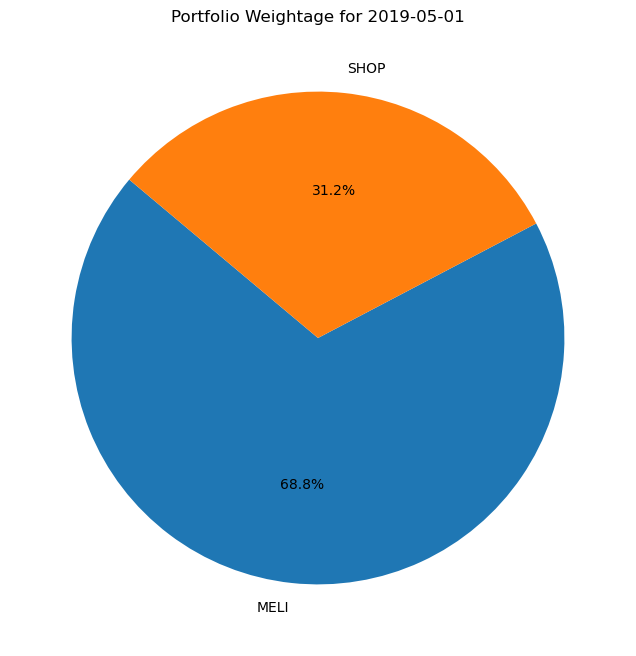




Portfolio for 2019-06-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'PDD', 'RKUNF', 'SHOP']


Optimal Weights: [3.96042645e-01 0.00000000e+00 4.53824859e-01 1.73472348e-18
 3.83749660e-02 1.11757530e-01 0.00000000e+00]




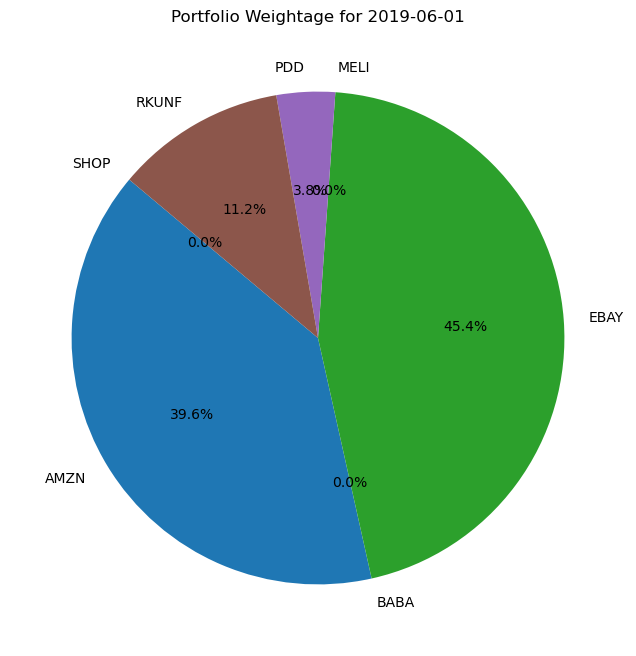




Portfolio for 2019-07-01: ['BABA', 'EBAY', 'MELI', 'PDD', 'SHOP']


Optimal Weights: [0.02493225 0.77977079 0.09521031 0.06966901 0.03041765]




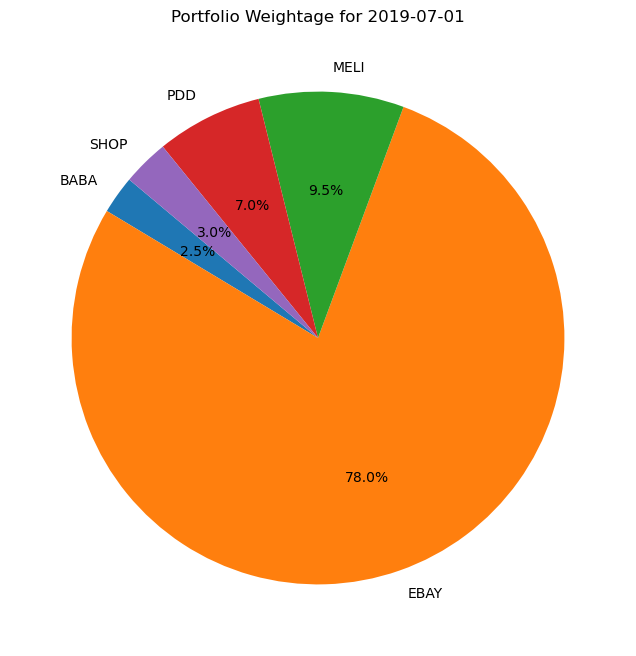




Portfolio for 2019-08-01: ['BABA', 'PDD', 'SHOP']


Optimal Weights: [0.4979336  0.05169469 0.45037171]




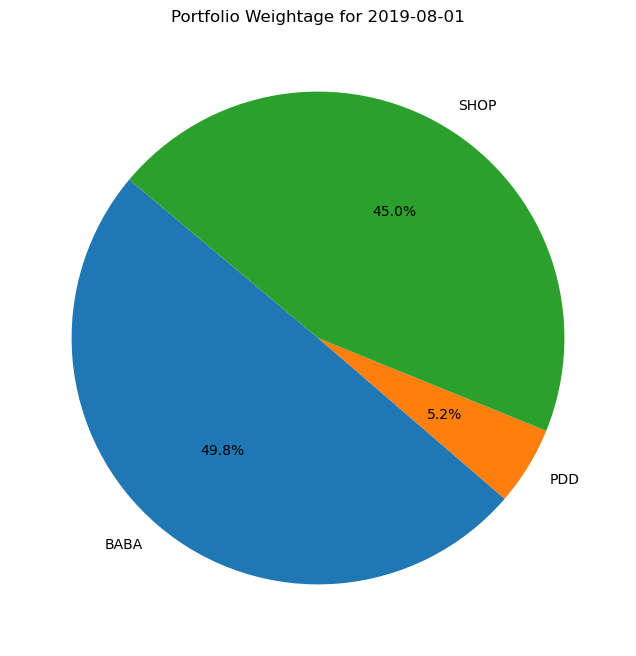




Portfolio for 2019-09-01: ['RKUNF']


Optimal Weights: [1.]




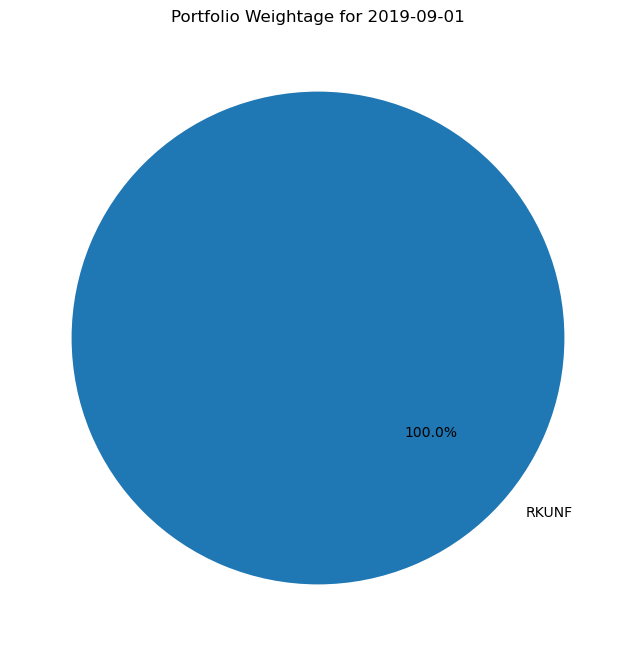




Portfolio for 2019-10-01: ['AMZN', 'BABA', 'PDD', 'RKUNF']


Optimal Weights: [0.72562774 0.05175467 0.04430005 0.17831754]




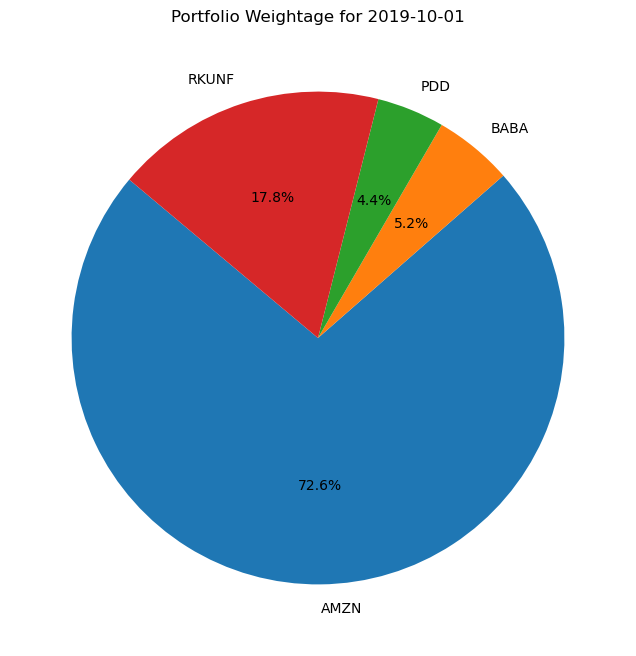




Portfolio for 2019-11-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'SHOP']


Optimal Weights: [4.41897364e-01 1.20749998e-02 5.46027636e-01 0.00000000e+00
 6.93889390e-18]




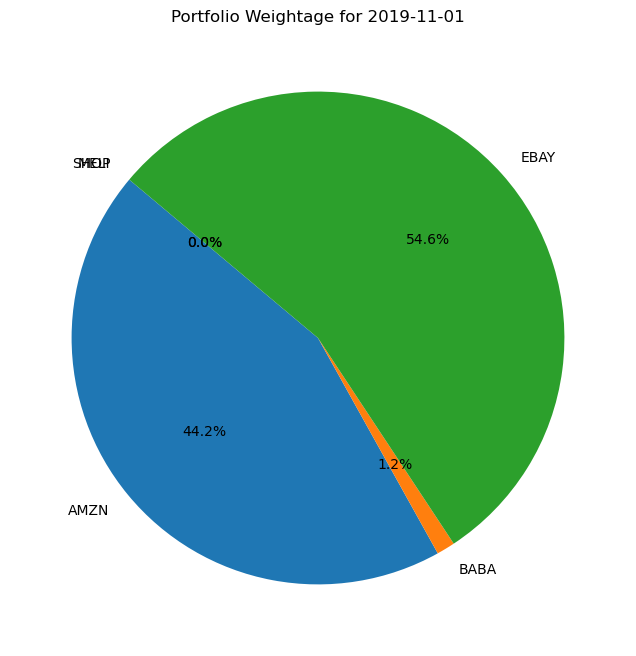




Portfolio for 2019-12-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'PDD', 'RKUNF', 'SHOP']


Optimal Weights: [3.96042645e-01 0.00000000e+00 4.53824859e-01 1.73472348e-18
 3.83749660e-02 1.11757530e-01 0.00000000e+00]




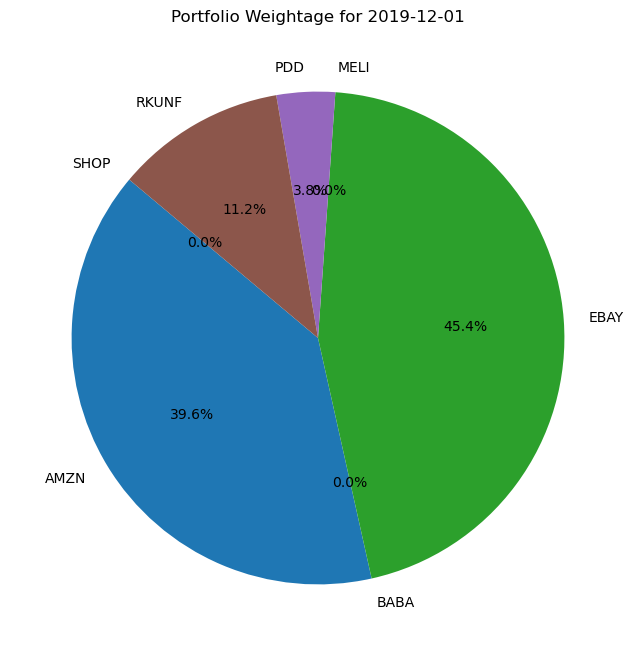




Portfolio for 2020-01-01: ['AMZN', 'MELI', 'SHOP']


Optimal Weights: [8.84769614e-01 1.15230386e-01 1.53956708e-17]




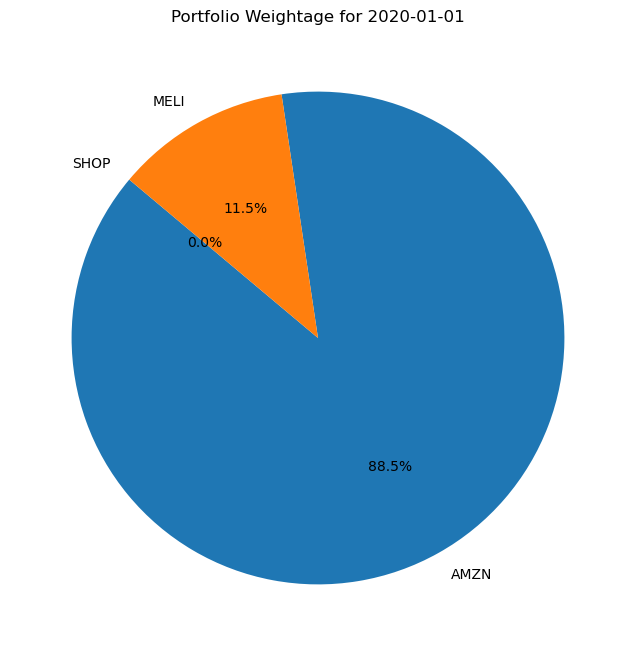




Portfolio for 2020-02-01: ['RKUNF']


Optimal Weights: [1.]




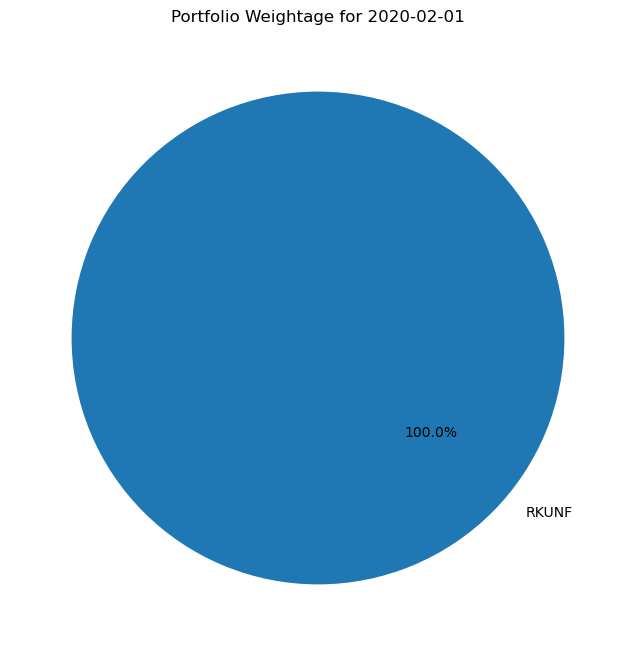




Portfolio for 2020-03-01: ['AMZN', 'PDD', 'RKUNF']


Optimal Weights: [0.723253   0.07031656 0.20643043]




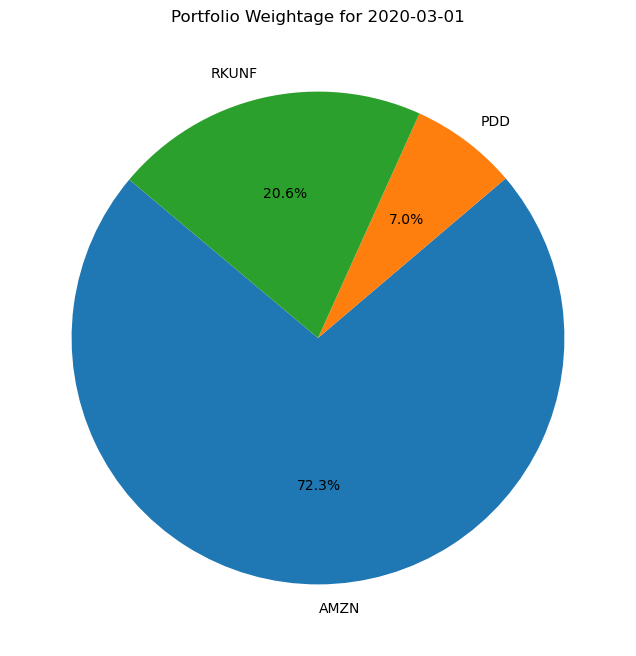




Portfolio for 2020-04-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'PDD', 'RKUNF', 'SHOP']


Optimal Weights: [3.96042645e-01 0.00000000e+00 4.53824859e-01 1.73472348e-18
 3.83749660e-02 1.11757530e-01 0.00000000e+00]




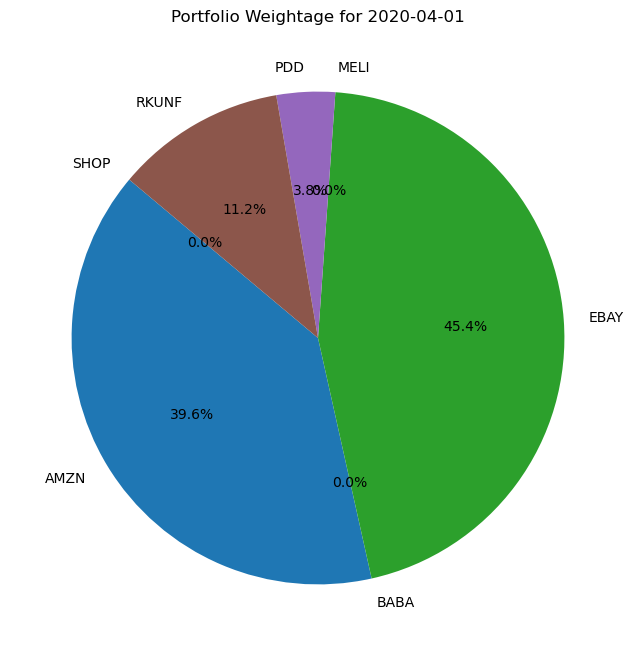




Portfolio for 2020-05-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'PDD', 'RKUNF', 'SHOP']


Optimal Weights: [3.96042645e-01 0.00000000e+00 4.53824859e-01 1.73472348e-18
 3.83749660e-02 1.11757530e-01 0.00000000e+00]




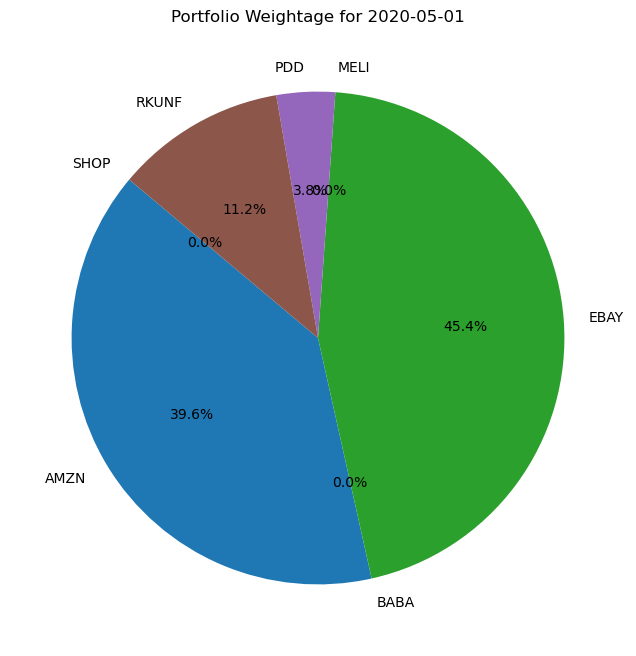




Portfolio for 2020-06-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'PDD', 'SHOP']


Optimal Weights: [4.19252293e-01 0.00000000e+00 5.05325673e-01 2.94680432e-02
 4.59539904e-02 4.33680869e-19]




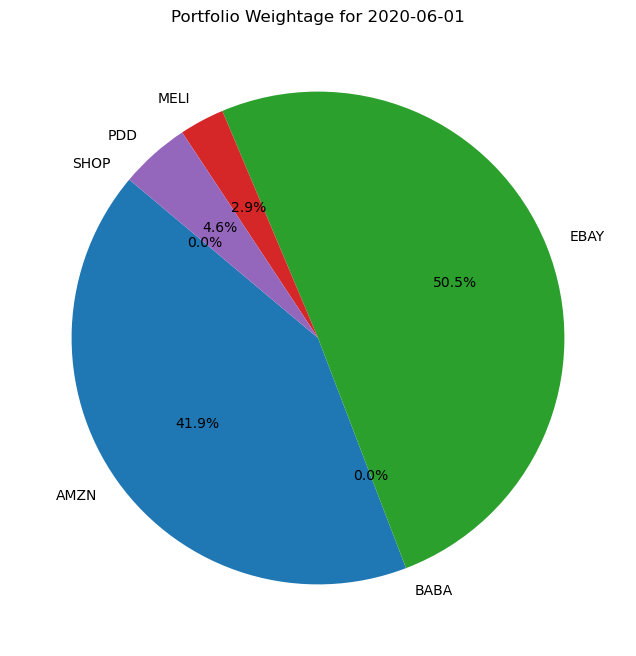




Portfolio for 2020-07-01: ['AMZN', 'BABA', 'MELI', 'PDD', 'RKUNF', 'SHOP']


Optimal Weights: [6.04869142e-01 1.34441069e-17 9.90114715e-02 6.30913230e-02
 2.33028063e-01 5.42101086e-18]




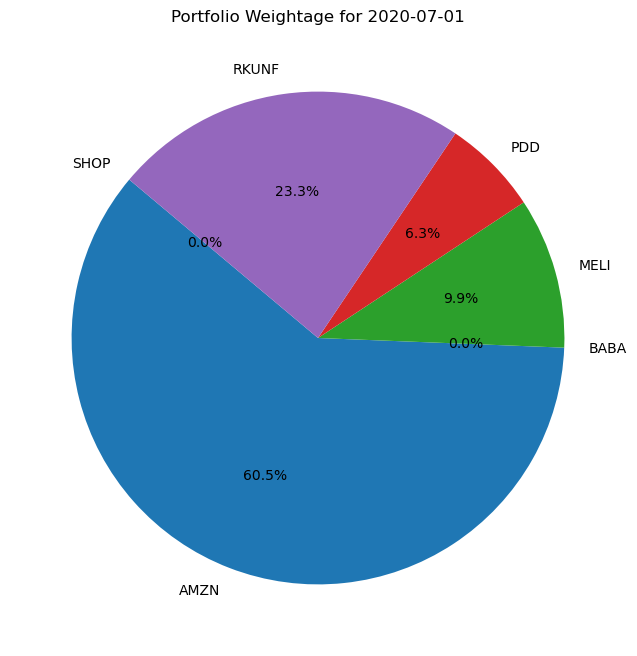




Portfolio for 2020-08-01: ['AMZN', 'BABA', 'MELI', 'SHOP']


Optimal Weights: [8.27797461e-01 1.10539741e-01 6.16627973e-02 8.67361738e-18]




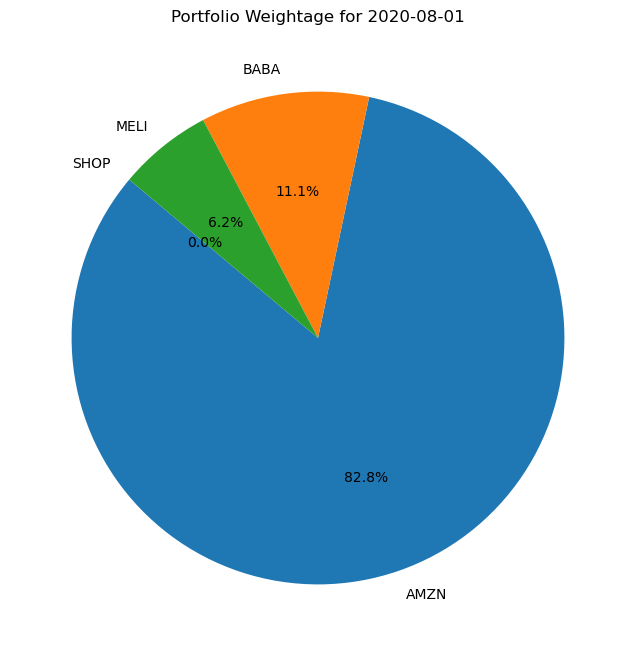




Portfolio for 2020-09-01: ['EBAY', 'RKUNF']


Optimal Weights: [0.80760594 0.19239406]




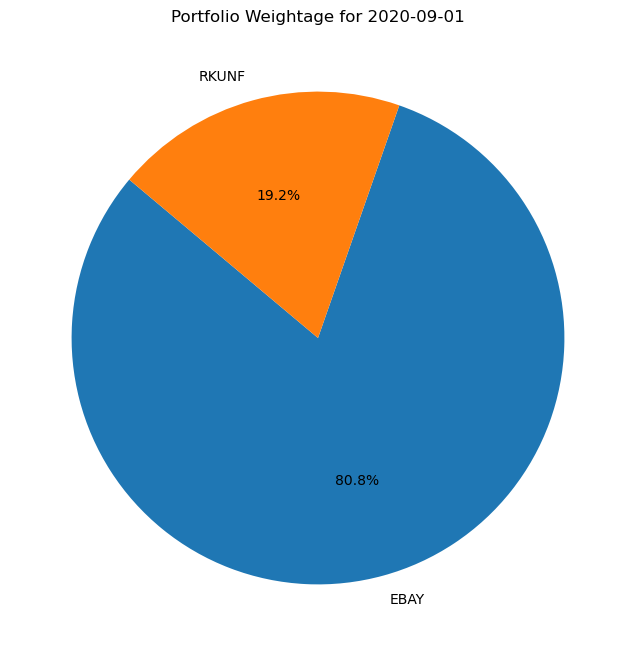




Portfolio for 2020-10-01: ['BABA', 'MELI', 'PDD']


Optimal Weights: [0.41940137 0.53734989 0.04324875]




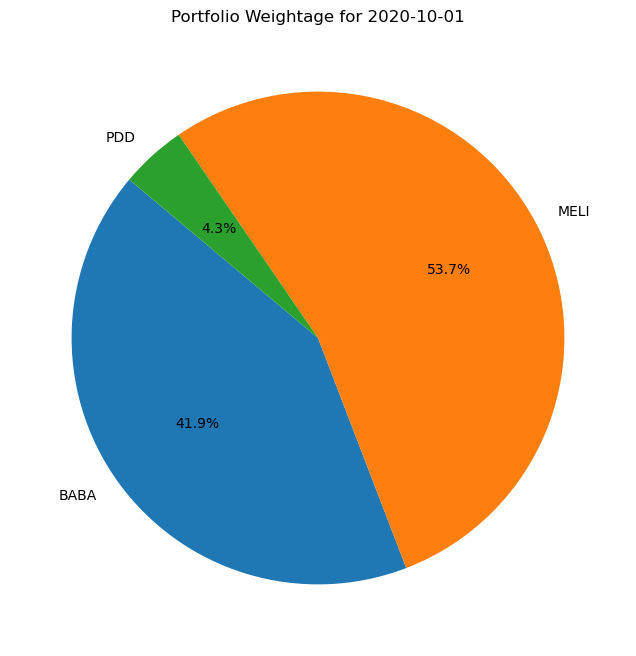




Portfolio for 2020-11-01: ['AMZN', 'EBAY', 'MELI', 'PDD', 'RKUNF', 'SHOP']


Optimal Weights: [3.97204591e-01 4.51146919e-01 9.64293119e-03 4.28013918e-02
 9.92041667e-02 8.89045781e-18]




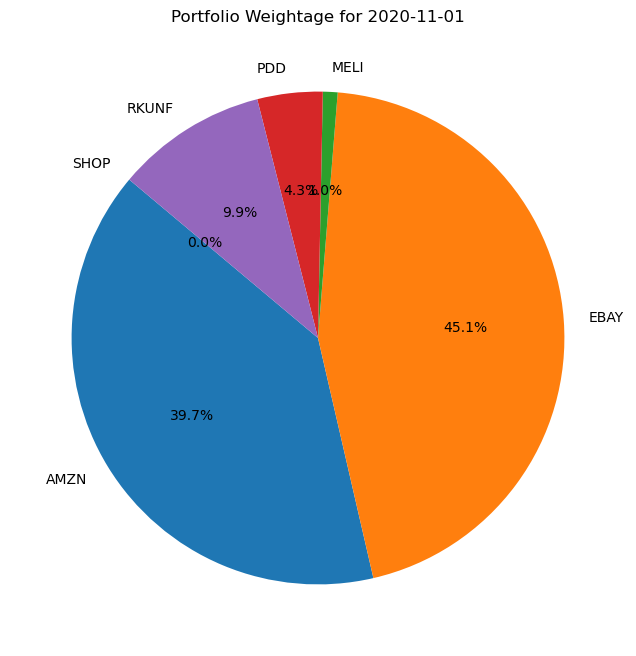




Portfolio for 2020-12-01: ['AMZN', 'MELI', 'PDD', 'SHOP']


Optimal Weights: [8.52823204e-01 6.47994744e-02 8.23773220e-02 1.12757026e-17]




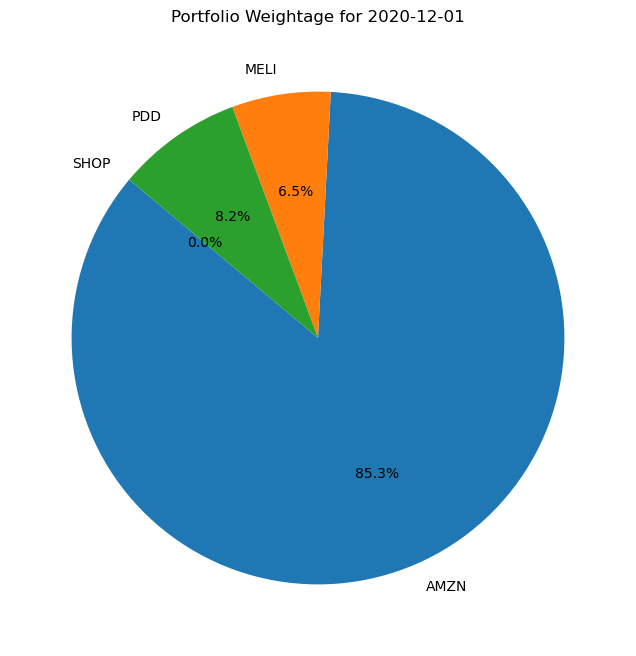




Portfolio for 2021-01-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'RKUNF']


Optimal Weights: [0.35417976 0.         0.39412141 0.07971862 0.17198022]




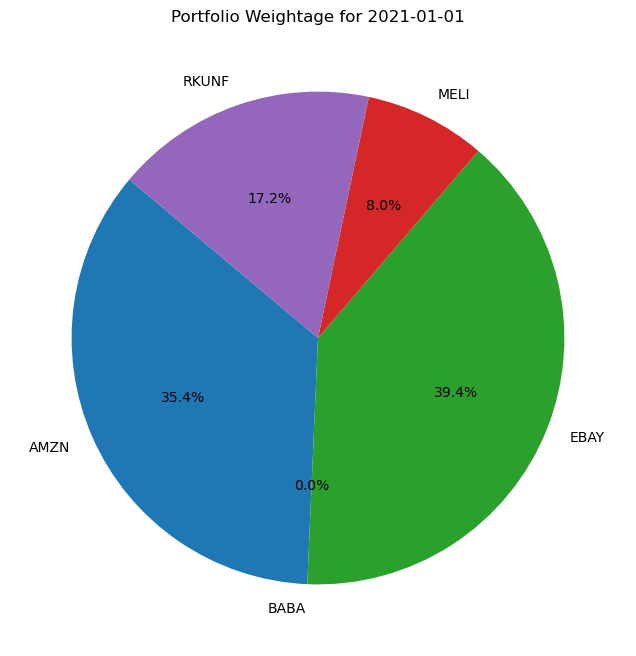




Portfolio for 2021-02-01: ['RKUNF', 'SHOP']


Optimal Weights: [0.5 0.5]




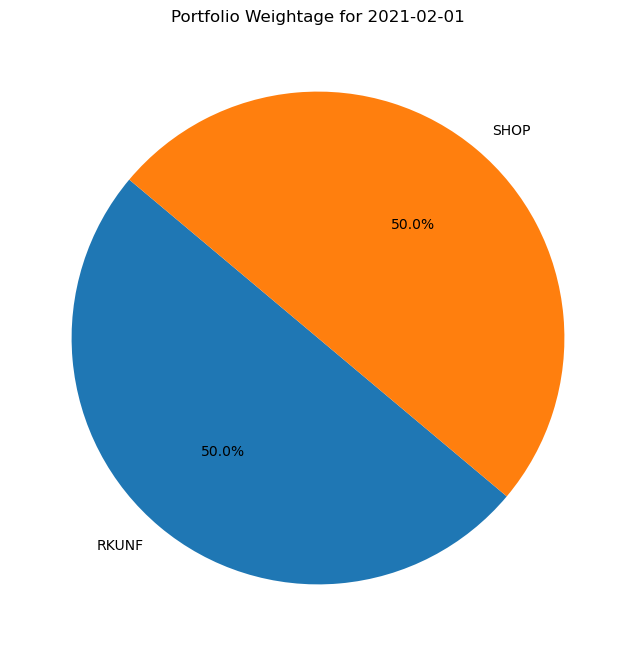




Portfolio for 2021-03-01: ['EBAY', 'RKUNF']


Optimal Weights: [0.80760594 0.19239406]




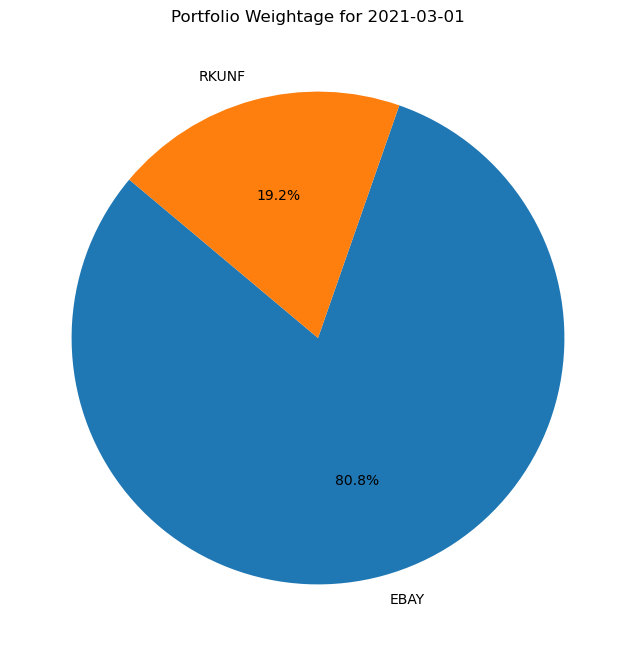




Portfolio for 2021-04-01: ['AMZN', 'BABA', 'MELI', 'RKUNF', 'SHOP']


Optimal Weights: [6.55925940e-01 1.98339307e-02 1.26291148e-01 1.97948982e-01
 1.38777878e-17]




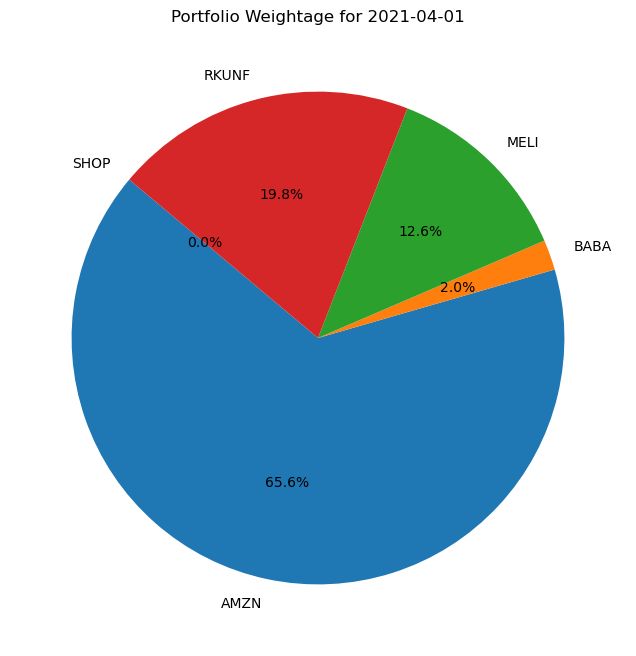




Portfolio for 2021-05-01: ['EBAY', 'SHOP']


Optimal Weights: [0.88003148 0.11996852]




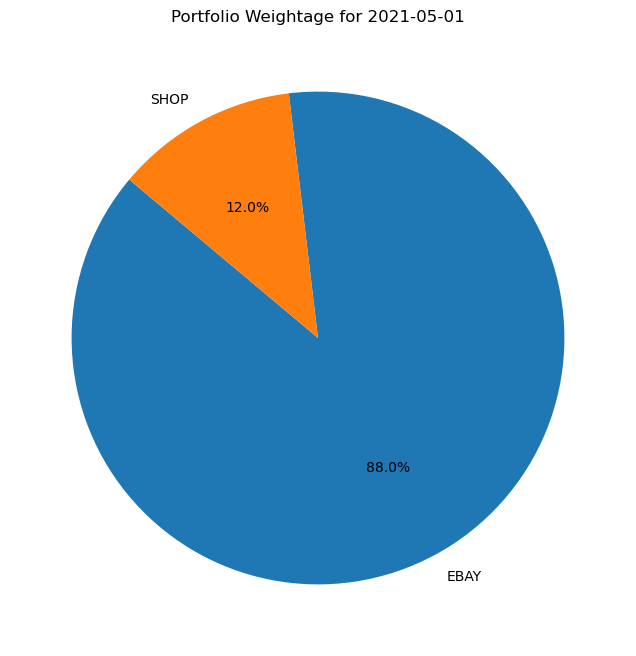




Portfolio for 2021-06-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'SHOP']


Optimal Weights: [4.41897364e-01 1.20749998e-02 5.46027636e-01 0.00000000e+00
 6.93889390e-18]




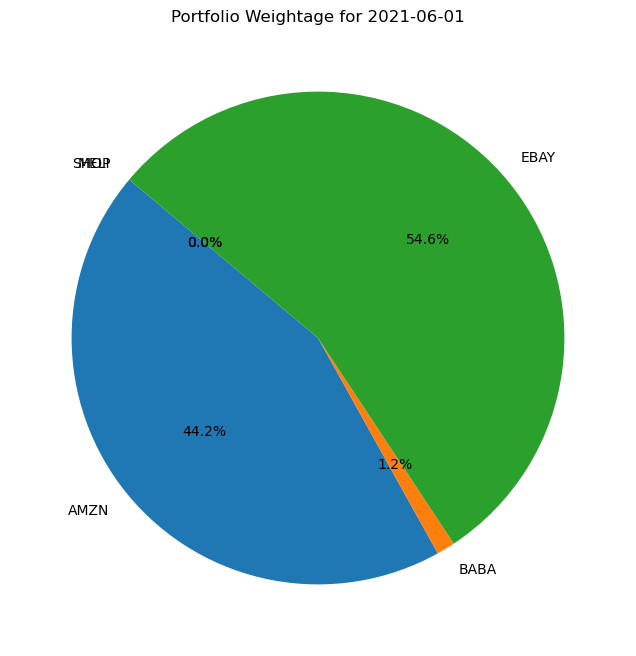




Portfolio for 2021-07-01: ['EBAY', 'MELI', 'SHOP']


Optimal Weights: [0.78042314 0.21200916 0.0075677 ]




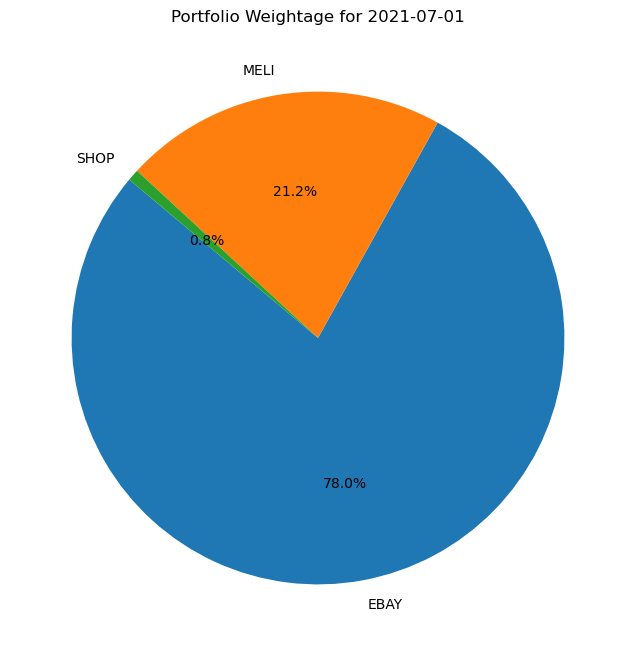




Portfolio for 2021-08-01: ['AMZN', 'EBAY', 'MELI', 'PDD', 'SHOP']


Optimal Weights: [4.32597813e-01 5.16707973e-01 0.00000000e+00 5.06942140e-02
 9.18861341e-18]




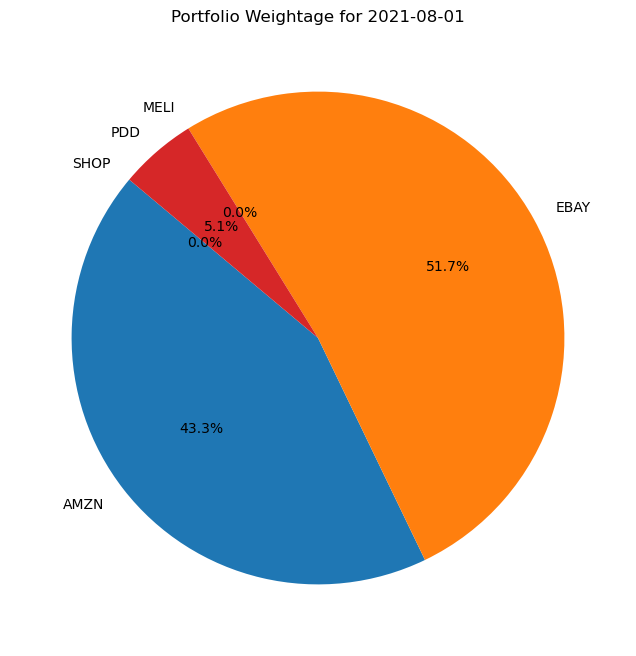




Portfolio for 2021-10-01: ['AMZN', 'BABA', 'EBAY', 'PDD', 'RKUNF', 'SHOP']


Optimal Weights: [0.36107837 0.         0.40493948 0.06326614 0.17071601 0.        ]




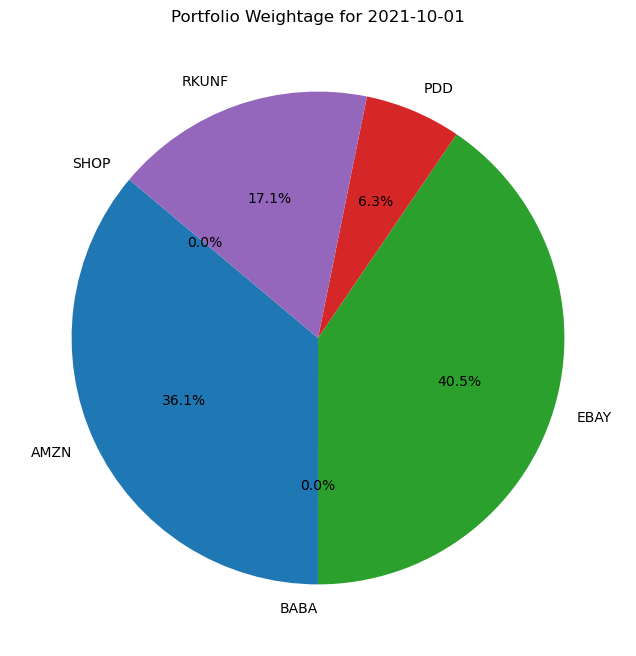




Portfolio for 2021-11-01: ['AMZN', 'SHOP']


Optimal Weights: [0.98717105 0.01282895]




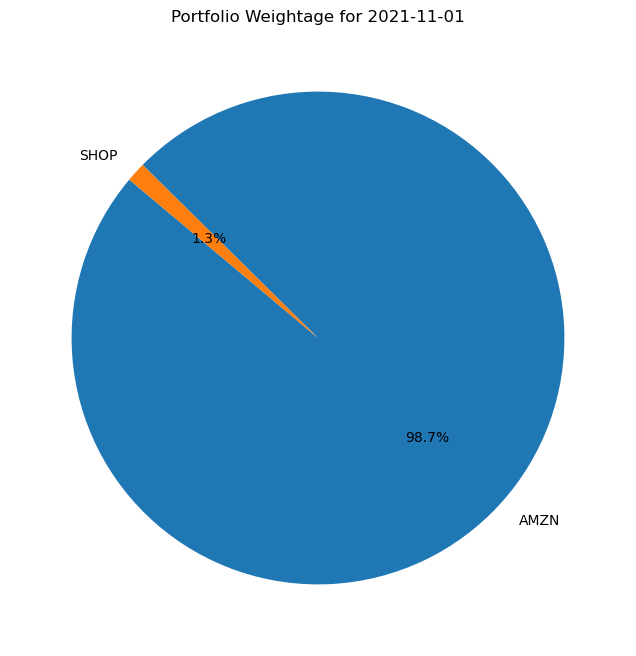




Portfolio for 2021-12-01: ['EBAY', 'MELI']


Optimal Weights: [0.82237455 0.17762545]




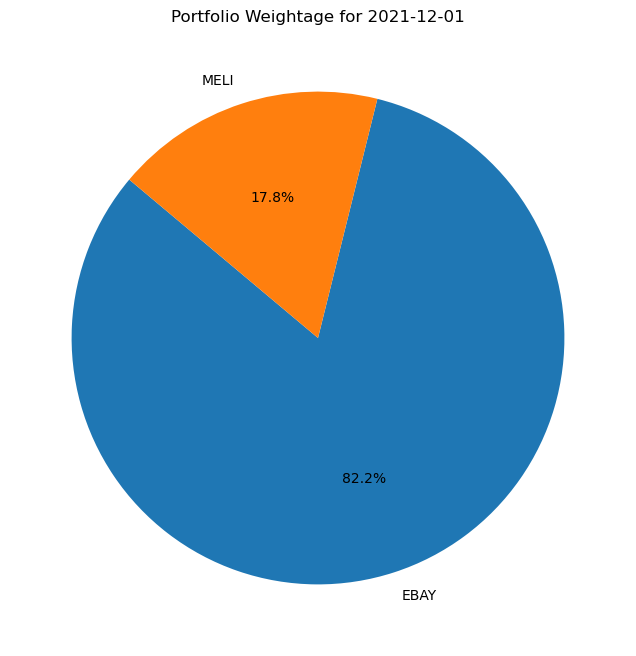




Portfolio for 2022-03-01: ['AMZN', 'BABA', 'EBAY', 'MELI', 'SHOP']


Optimal Weights: [4.41897364e-01 1.20749998e-02 5.46027636e-01 0.00000000e+00
 6.93889390e-18]




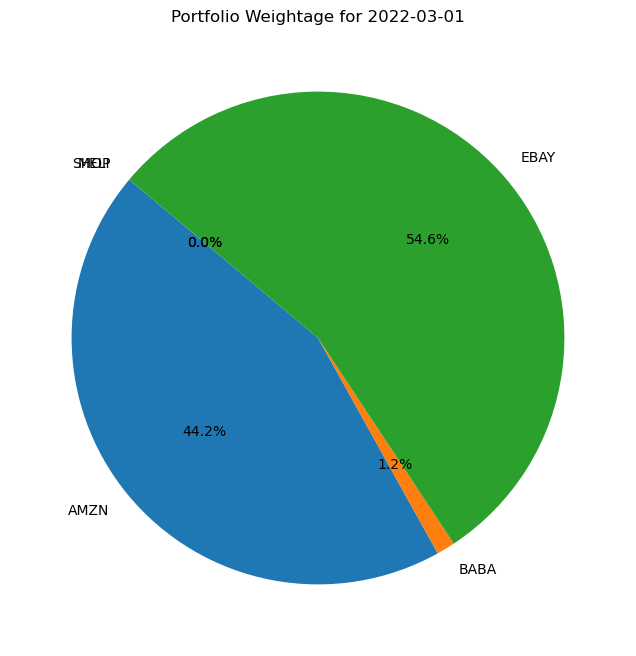




Portfolio for 2022-05-01: ['AMZN', 'BABA', 'PDD']


Optimal Weights: [0.88168199 0.05419016 0.06412784]




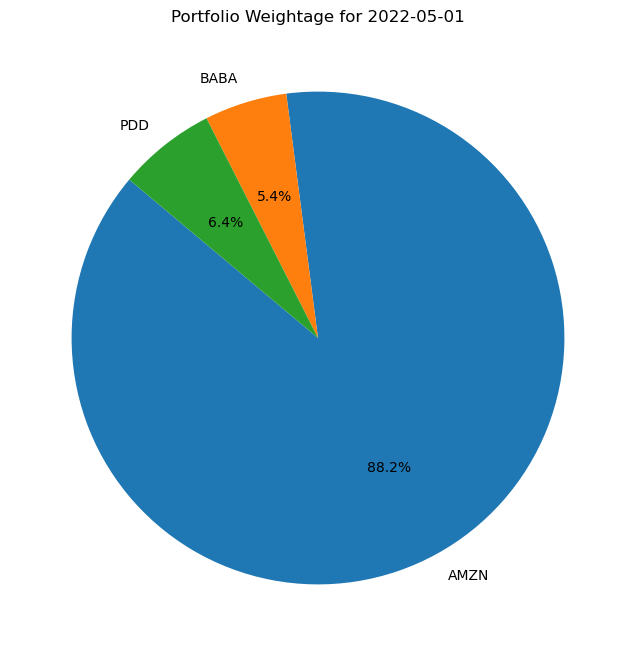

In [ ]:
print("Optimized Portfolios:")

for date, portfolio, weights in optimal_weights_list:
    print(f"\nPortfolio for {date.strftime('%Y-%m-%d')}: {portfolio}")
    print("\n")
    print(f"Optimal Weights: {weights}")
    print("\n")
    plot_pie_chart(date, portfolio, weights)
    print("\n")

In [ ]:
portfolio_periods = []
for date, portfolio, weights in optimal_weights_list:
    portfolio_periods.append((date, portfolio, weights))

In [ ]:
net_cagr = calculate_cagr(optimal_weights_list)
if net_cagr is not None:
    print("\n")
    print(f"Net CAGR for the entire duration: {net_cagr * 100:.2f}%")
else:
    print("Net CAGR: Not Calculated (Incomplete Data)")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******



Net CAGR for the entire duration: 4.88%
